In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# init_mass_arr = np.arange(70, 151, 10)
# CO_mass_core_arr = np.full(init_mass_arr.shape, np.nan)
# for i, init_mass in enumerate(init_mass_arr):
#     datadir = Path('Over_00/%03d'%init_mass)
#     # chemistry
#     df_evolution_keyproperty = pd.DataFrame(columns=['model', 'COcore_mass'], dtype=(str, float))
#     for datapath in datadir.iterdir():
#         if datapath.suffix == '.chi':
#             model_name = datapath.stem
#             df = pd.read_table(datapath, sep='\s+', index_col=0)
#             df['COfrac'] = np.sum(df.loc[:, ['C12', 'C13', 'O15', 'O16', 'O17']], axis=1)
#             idx_COcore_edge = np.diff(df.loc[:, 'COfrac']).argmax()
#             M_mesh = np.diff(df.loc[1:idx_COcore_edge+1, 'M'].values)
#             COfrac_mesh = df.loc[1:idx_COcore_edge, 'COfrac'].values
#             COcore_mass = np.dot(M_mesh, COfrac_mesh)
#             df_evolution_keyproperty.loc[len(df_evolution_keyproperty)] = [model_name, COcore_mass]
#     df_evolution_keyproperty = df_evolution_keyproperty.sort_values('model', ignore_index=True)
#     idx_Cigni = df_evolution_keyproperty.loc[:, 'COcore_mass'].argmax()
#     if idx_Cigni == df_evolution_keyproperty.index.max():
#         continue
#     else:
#         CO_mass_core_arr[i] = df_evolution_keyproperty.loc[idx_Cigni, 'COcore_mass']

In [15]:
overshoot = 0.0
init_mass_arr = np.arange(70, 151, 10)
CO_mass_core_arr = np.full(init_mass_arr.shape, np.nan)
for i, init_mass in enumerate(init_mass_arr):
    datadir = Path('Over_%02d/%03d'%(overshoot, init_mass))
    # chemistry
    df_evolution_keyproperty = pd.DataFrame(columns=['model', 'COcore_mass'], dtype=(str, float))
    for datapath in datadir.iterdir():
        if datapath.suffix == '.chi':
            model_name = datapath.stem
            df = pd.read_table(datapath, sep='\s+', index_col=0)
            df['COfrac'] = np.sum(df.loc[:, ['He3', 'He4']], axis=1)
            idx_COcore_edge = np.diff(df.loc[:, 'COfrac']).argmax()
            M_mesh = np.diff(df.loc[1:idx_COcore_edge+1, 'M'].values)
            COfrac_mesh = df.loc[1:idx_COcore_edge, 'COfrac'].values
            COcore_mass = np.dot(M_mesh, COfrac_mesh)
            df_evolution_keyproperty.loc[len(df_evolution_keyproperty)] = [model_name, COcore_mass]
    df_evolution_keyproperty = df_evolution_keyproperty.sort_values('model', ignore_index=True)
    idx_Cigni = df_evolution_keyproperty.loc[:, 'COcore_mass'].argmax()
    # break
    if idx_Cigni == df_evolution_keyproperty.index.max():
        continue
    else:
        CO_mass_core_arr[i] = df_evolution_keyproperty.loc[idx_Cigni, 'COcore_mass']

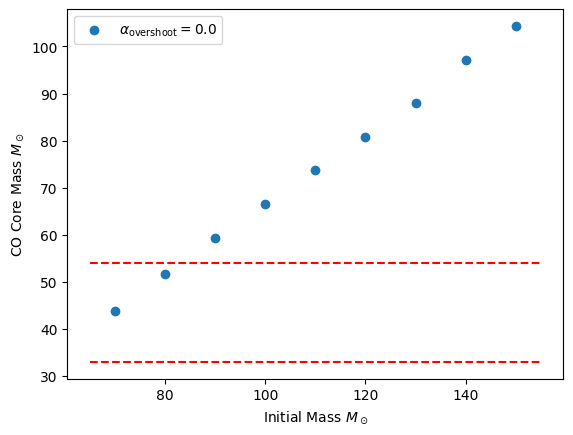

In [16]:
plt.scatter(init_mass_arr, CO_mass_core_arr, label=r'$\alpha_\mathrm{overshoot}=%.1f$'%overshoot)
plt.ylabel(r'$\mathrm{CO\ Core\ Mass}\ M_\odot$')
plt.xlabel(r'$\mathrm{Initial\ Mass}\ M_\odot$')
plt.hlines([33, 54], xmin=65, xmax=155, linestyles='dashed', colors='r')
# plt.ylim(19, 60)
plt.legend()

In [6]:
# physical structure

In [44]:
(datadir/'0022700').suffix

''

In [103]:
# kippenhahn
overshoot = 0.0
init_mass_arr = np.arange(70, 151, 10)
CO_mass_core_arr = np.full(init_mass_arr.shape, np.nan)
for i, init_mass in enumerate(init_mass_arr[:1]):
    datadir = Path('Over_%02d/%03d'%(overshoot, init_mass))
    model_info = pd.DataFrame(columns=['name', 'age'], dtype=float)
    model_names = []
    for _path in datadir.iterdir():
        if (_path.suffix == '.atm'):
            model_names.append(_path.stem)
    # fort54 = pd.read_csv(datadir/'fort.54', delimiter='\s+', header=None)
    model_names.sort()
    model_info['name'] = model_names
    for idx, row in model_info.iterrows():
        model_name = row['name']
        df_f01 = pd.read_csv(datadir/('%s.f01'%model_name), delimiter='\s+')
        df_qva = pd.read_csv(datadir/('%s.qva'%model_name), delimiter='\s+')
        age = df_qva.loc[0, 'AGE']
        model_info.loc[idx, 'age'] = age
    model_info['logt'] = np.log10(model_info['age'].values[-1]-model_info['age'].values+0.01)
    # mass_mesh = datadir
    # df_keyproperty = pd.DataFrame(columns=['model', 'time', ], dtype=(str, float))
    

In [108]:
df_f01

,MESH,M/MTOT,R/RTOT,LOG(P),LOG(T),LOG(RO),RAD-DAD,G-RAD,G-AD,CAP,...,V-CIRC-MERID,RICH-NUMB,difadsi,difassi,difaes,difashi,nil,nil.1,nil.2,nil.3
1,0.000040,0.000348,22.44303,9.10939,5.52419,-0.200739,0.065165,0.265904,-1.237010,0.751148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000081,0.000700,22.44274,9.10937,5.52386,-0.200748,0.065144,0.265892,-1.237000,0.751024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000084,0.000707,22.44273,9.10937,5.52384,-0.200733,0.065158,0.265892,-1.237000,0.751019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000086,0.000714,22.44272,9.10937,5.52383,-0.200736,0.065156,0.265892,-1.237000,0.751014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000089,0.000721,22.44271,9.10937,5.52382,-0.200796,0.065095,0.265891,-1.237000,0.751009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,69.251984,57.226700,9.44177,5.93767,-4.95860,-0.013107,0.246297,0.259404,-0.435572,0.486761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1212,69.270659,57.473630,9.42454,5.93336,-4.97152,-0.013044,0.246369,0.259413,-0.435346,0.486767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1213,69.284686,57.662110,9.41130,5.93007,-4.98155,-0.013015,0.246379,0.259394,-0.435178,0.486679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1214,69.292156,57.763920,9.40416,5.92831,-4.98699,-0.013052,0.246369,0.259421,-0.435089,0.486598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
df_qva

,AGE,DT,L,TE,R,GR,M,E,DM,ITERAZ,MAXME,NMD
0,6.601329,-3.5065,6.0962,4.2346,2.1019,2.08,70.0,0.0,0.0,4,1216,28450


In [106]:
model_info

,name,age,logt
0,0022600,4.147269,0.391651
1,0022650,4.669364,0.288241
2,0022700,6.302371,-0.510101
3,0022750,6.479193,-0.878979
4,0022800,6.524013,-1.058910
...,...,...,...
113,0028250,6.601329,-2.000000
114,0028300,6.601329,-2.000000
115,0028350,6.601329,-2.000000
116,0028400,6.601329,-2.000000
